# Plotting Data

In [14]:
import pickle

# Load X arrays
with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y arrays
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)


print("Original X_train shape:", X_train.shape)
print("Original y_train shape:", y_train.shape)
print("Original X_test shape:", X_test.shape)
print("Original y_test shape:", y_test.shape)

Original X_train shape: (248036, 8)
Original y_train shape: (248036,)
Original X_test shape: (106302, 8)
Original y_test shape: (106302,)


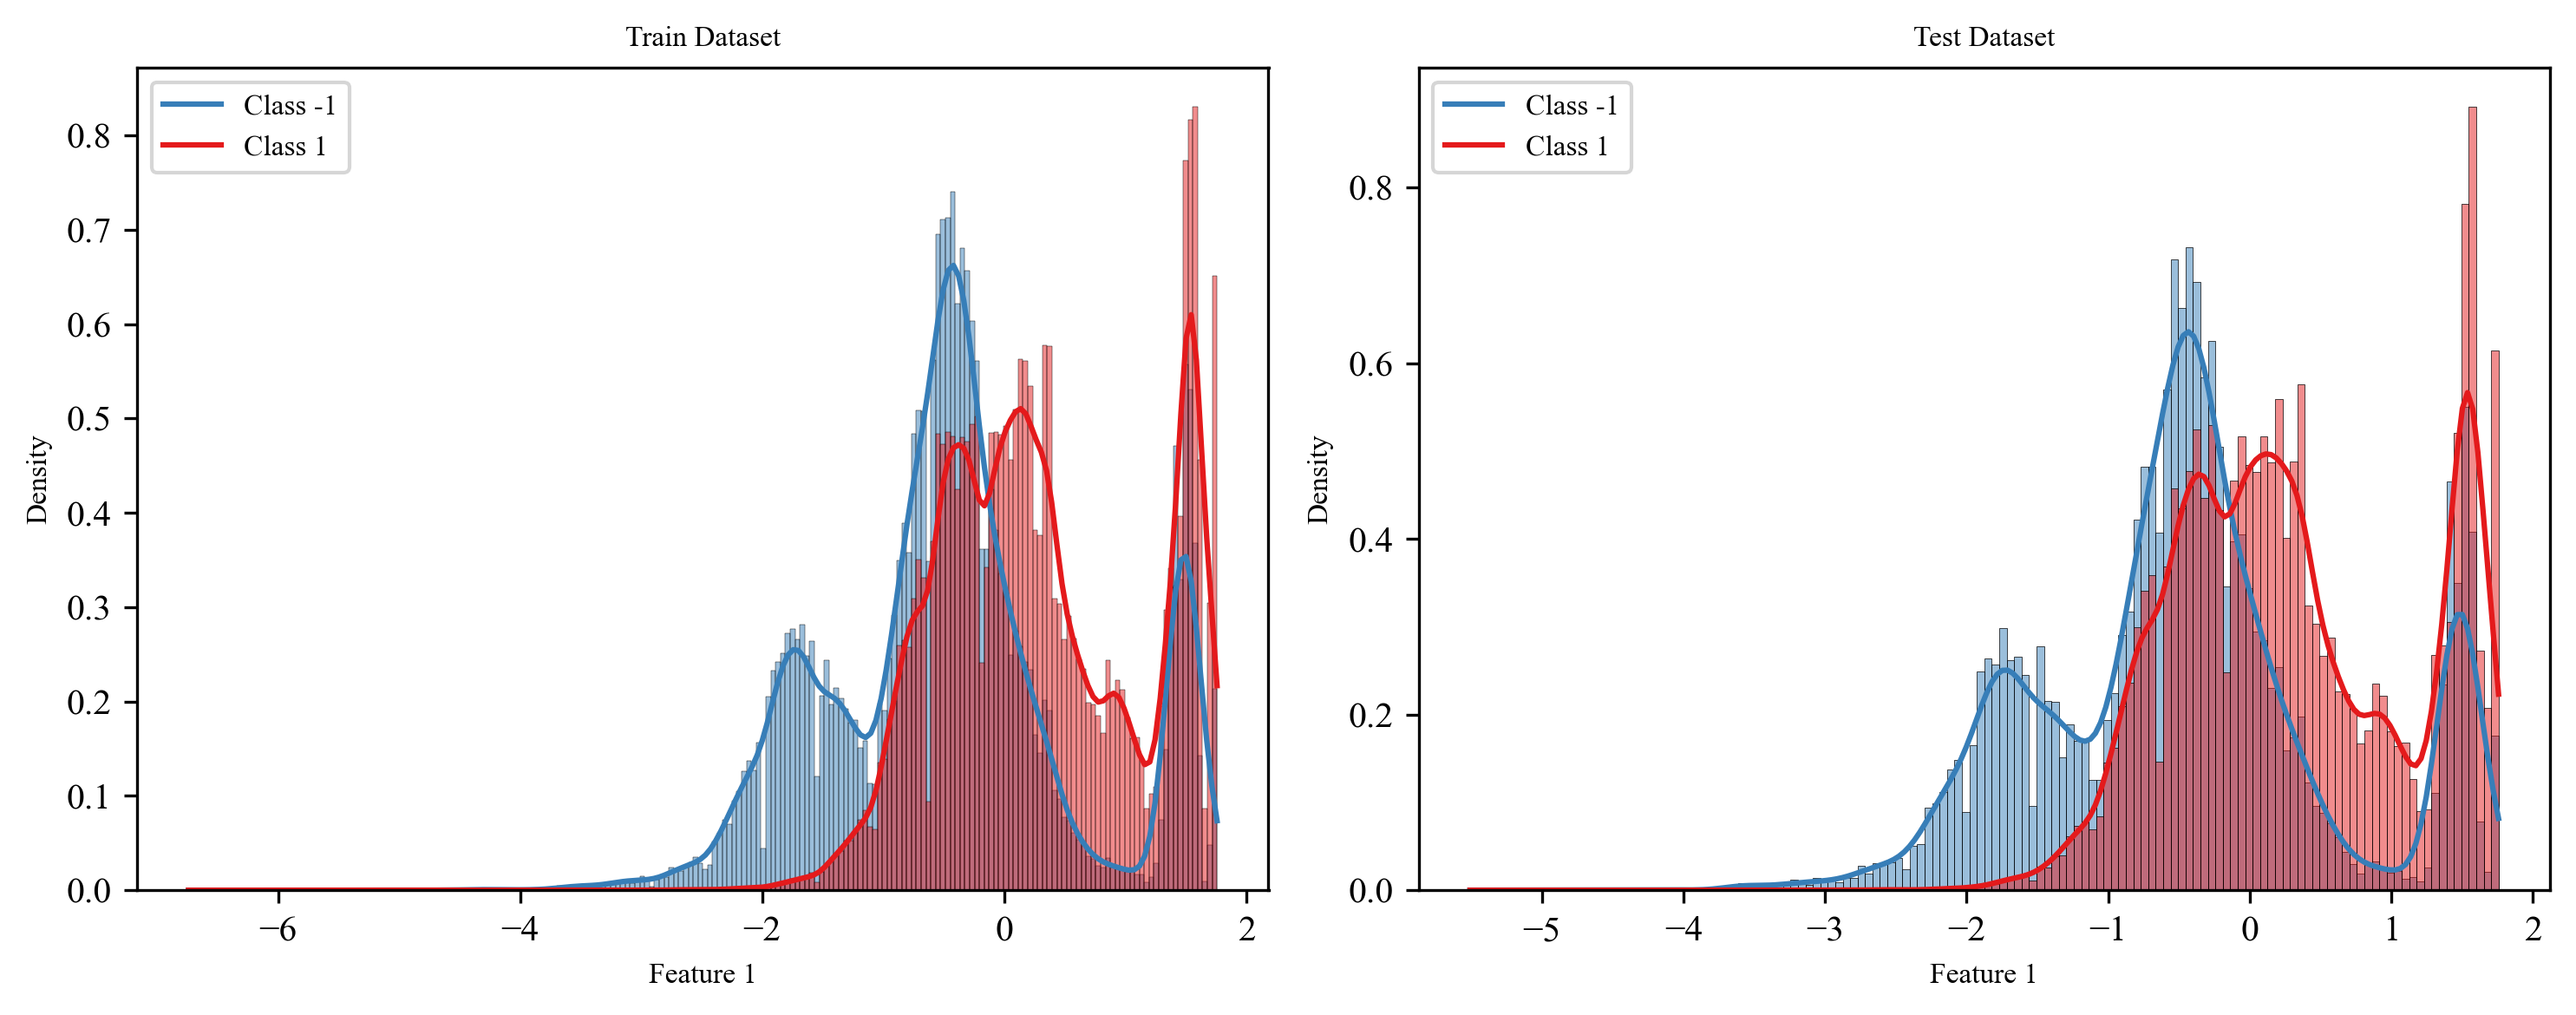

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Global plotting style
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 300
sns.set_style(None)

# Map numeric labels to strings
y_train_str = np.where(y_train == 1, 'Class 1', 'Class -1')
y_test_str  = np.where(y_test == 1, 'Class 1', 'Class -1')

plt.figure(figsize=(10, 4))

# Train
ax1 = plt.subplot(1, 2, 1)
sns.histplot(
    x=X_train[:, 0],
    hue=y_train_str,
    kde=True,
    stat="density",
    common_norm=False,
    palette="Set1",
    legend=False,  # force manual legend
    ax=ax1
)
ax1.legend(labels=np.unique(y_train_str), fontsize=8)
ax1.set_title("Train Dataset", fontsize=8)
ax1.set_xlabel("Feature 1", fontsize=8)
ax1.set_ylabel("Density", fontsize=8)
ax1.grid(False)

# Test
ax2 = plt.subplot(1, 2, 2)
sns.histplot(
    x=X_test[:, 0],
    hue=y_test_str,
    kde=True,
    stat="density",
    common_norm=False,
    palette="Set1",
    legend=False,
    ax=ax2
)
ax2.legend(labels=np.unique(y_test_str), fontsize=8)
ax2.set_title("Test Dataset", fontsize=8)
ax2.set_xlabel("Feature 1", fontsize=8)
ax2.set_ylabel("Density", fontsize=8)
ax2.grid(False)
plt.tight_layout()
plt.show()


# Balancing the dataset

In [18]:
import numpy as np
import matplotlib.pyplot as plt

X_all = np.vstack([X_train, X_test])
y_all = np.concatenate([y_train, y_test])

# ---------------------------
# Step 2: Balance classes
# ---------------------------
np.random.seed(42)

# Find indices for each class
idx_pos = np.where(y_all == 1)[0]
idx_neg = np.where(y_all == -1)[0]

# Choose same number of samples for each class
n_samples_per_class = min(len(idx_pos), len(idx_neg))
sel_pos = np.random.choice(idx_pos, n_samples_per_class, replace=False)
sel_neg = np.random.choice(idx_neg, n_samples_per_class, replace=False)

# Combine selected indices and shuffle
selected_idx = np.concatenate([sel_pos, sel_neg])
np.random.shuffle(selected_idx)

X_bal = X_all[selected_idx]
y_bal = y_all[selected_idx]

# ---------------------------
# Step 4: Shuffle and split back to train/test
# ---------------------------
np.random.seed(42)
perm = np.random.permutation(len(y_bal))
X_bal = X_bal[perm]
y_bal = y_bal[perm]

# For example, 70% train, 30% test
split = int(0.7 * len(y_bal))
X_train_new = X_bal[:split]
y_train_new = y_bal[:split]
X_test_new = X_bal[split:]
y_test_new = y_bal[split:]

print("New X_train shape:", X_train_new.shape)
print("New y_train shape:", y_train_new.shape)
print("New X_test shape:", X_test_new.shape)
print("New y_test shape:", y_test_new.shape)

print("Train Class -1:", np.sum(y_train_new == -1))
print("train Class 1 :", np.sum(y_train_new == 1))


print("Test Class -1:", np.sum(y_test_new == -1))
print("Test Class 1 :", np.sum(y_test_new == 1))

New X_train shape: (201993, 8)
New y_train shape: (201993,)
New X_test shape: (86569, 8)
New y_test shape: (86569,)
Train Class -1: 101144
train Class 1 : 100849
Test Class -1: 43137
Test Class 1 : 43432


# SVM_BM

In [106]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# ----------------------------------------
# Loss function ℓ(g, (x,y)): hinge loss
# ----------------------------------------
def hinge_loss(clf, x, y):
    """
    x: 1D feature vector
    y: scalar label in {-1, +1}
    """
    # decision_function returns margin f(x)
    s = clf.decision_function(x.reshape(1, -1))[0]
    loss = max(0.0, 1.0 - y * s)
    return loss, s  # return both loss and score (for the special case)


def test_accuracy(clf, X, y):
    y_pred = clf.predict(X)
    return accuracy_score(y, y_pred)


# ----------------------------------------
# Algorithm 1: SVM-BM (closely following the paper)
# ----------------------------------------
def svm_bm(Dtrain, n2, q, N, T, C, Dtest=None, random_state=None):
    rng = np.random.default_rng(random_state)

    # unpack data
    y_full = Dtrain[:, 0]
    X_full = Dtrain[:, 1:]

    # ------------------------------------
    # Step 0: Draw D0 and train g0
    # ------------------------------------
    idx0 = rng.choice(len(Dtrain), size=N, replace=False)
    D0 = Dtrain[idx0].copy()           # shape (N, d+1)
    X0, y0 = D0[:, 1:], D0[:, 0]

    g0 = SVC(kernel="linear", C=C)
    g0.fit(X0, y0)

    g_list = [g0]
    alpha_list = []
    D_chain = [D0.copy()] 

    # pick initial z1 from Dtrain
    idx_z = rng.integers(len(Dtrain))
    z1 = Dtrain[idx_z].copy()          # (label + features)

    # current dataset for Markov chain
    D_prev = D0.copy()
    g_prev = g0

    t = 1
    while t <= T:
        t0 = time.time()

        # --------------------------------
        # Build D_t via Markov chain
        # --------------------------------
        D_t = D_prev.copy()  # start from previous chain
        i = 0
        n1 = 0
        counter =0

        while i < N:
            counter=counter +1
            # draw z* from Dtrain
            idx_star = rng.integers(len(Dtrain))
            z_star = Dtrain[idx_star]
            y_star = z_star[0]
            x_star = z_star[1:]

            # current state z_i (from previous chain)
            z_i = D_t[i]
            y_i = z_i[0]
            x_i = z_i[1:]

            # base acceptance probability
            L1, s1 = hinge_loss(g_prev, x_star, y_star)
            L2, s2 = hinge_loss(g_prev, x_i, y_i)

            p = min(1.0, np.exp(-L1) / np.exp(-L2))

            # if too many rejections, scale by q and force move
            if n1 > n2:
                p = min(1.0, q * p)
                D_t[i] = z_star
                i += 1
                n1 = 0
                continue  # go to next i

            # special case: p == 1 and y* y_i == 1
            if (p == 1.0) and (y_star * y_i == 1):
                p = np.exp(-y_star * s1) / np.exp(-y_i * s2)

            accepted = False
            if rng.random() < p:
                D_t[i] = z_star
                i += 1
                n1 = 0
                accepted = True

            if not accepted:
                n1 += 1

        # --------------------------------
        # Train g_t on D_t
        # --------------------------------
        
        X_t, y_t = D_t[:, 1:], D_t[:, 0]
        g_t = SVC(kernel="linear", C=C)
        g_t.fit(X_t, y_t)
        t1 = time.time()

        # training error e_t on full Dtrain
        acc_train = test_accuracy(g_t, X_full, y_full)
        e_t = 1.0 - acc_train

        # avoid division by zero or degenerate boosting
        if e_t <= 0 or e_t >= 0.5:
            # paper only says α_t<0 → discard; this also discards degenerate cases
            print(f"Iteration {t}: e_t={e_t:.4f} (degenerate), skipping this g_t.")
            # do NOT update D_prev/g_prev/z1/t in this case, just try again
            continue

        alpha_t = 0.5 * np.log((1.0 - e_t) / e_t)

        # set z1 <- last z_star (used in theory for next chain start)
        z1 = z_star.copy()

        if alpha_t < 0:
            # discard this classifier, do not advance t
            #print(f"Iteration {t}: alpha_t<0, discarding this round.")
            continue

        # accept this classifier
        g_list.append(g_t)
        alpha_list.append(alpha_t)
        D_chain.append(D_t.copy()) 

        # update chain and previous classifier for next iteration
        D_prev = D_t
        g_prev = g_t


        print(f"\n\nIteration {t}: acc_train={acc_train:.4f}, e_t={e_t:.4f}, alpha_t={alpha_t:.4f}")
        #losses = [hinge_loss(g_prev, zi[1:], zi[0])[0] for zi in D_t[t]]
        #plt.hist(losses)
        #print(np.bincount(D_t[t][:,0].astype(int)))
        print('D_t',D_t.shape)
        print('counter',counter)
        print("Training time (seconds) of T:", t1 - t0)



        t += 1

    # ------------------------------------
    # Final ensemble prediction function
    # f_T(x) = sign(sum_t alpha_t g_t(x))
    # ------------------------------------
    def predict_ensemble(X):
        # g0 is at index 0 but has no alpha; ensemble uses g_list[1:], alpha_list
        if not alpha_list:
            # fallback to g0 if boosting failed
            return g0.predict(X)
        scores = np.zeros(X.shape[0])
        for alpha_t, g_t in zip(alpha_list, g_list[1:]):
            scores += alpha_t * g_t.decision_function(X)
        return np.sign(scores)

    def decision_function_ensemble(X):
        # If no boosting happened, fallback to g0
        if not alpha_list:
            return g0.decision_function(X)
    
        scores = np.zeros(X.shape[0])
        for alpha_t, g_t in zip(alpha_list, g_list[1:]):
            scores += alpha_t * g_t.decision_function(X)
        return scores

    '''
    results = {"classifiers": g_list,
               "alphas": np.array(alpha_list),
               "predict_ensemble": predict_ensemble}
    '''
    results = {
        "classifiers": g_list,
        "alphas": np.array(alpha_list),
        "D_chain": D_chain,
        "predict_ensemble": predict_ensemble,
        "decision_function": decision_function_ensemble}

    # optional: evaluate on Dtest if provided
    print ('Dtest.shape :', Dtest.shape)
    if Dtest is not None:
        y_test = Dtest[:, 0]
        X_test = Dtest[:, 1:]
        y_pred_test = predict_ensemble(X_test)
        acc_test = accuracy_score(y_test, y_pred_test)
        results["test_accuracy"] = acc_test
        print("Ensemble test accuracy:", acc_test)

    return results


In [110]:
import time
N=10;
T=10;
n2=20;
q=0.7;


Dtrain = np.hstack([y_train.reshape(-1, 1), X_train])
Dtest  = np.hstack([y_test.reshape(-1, 1),  X_test])

print("\nSVM BM Training")
t0 = time.time()
res = svm_bm(Dtrain, n2, q, N, T, C=1, Dtest=Dtest, random_state=0)
print("Alphas:", res["alphas"])

t1 = time.time()
print("Training time (seconds):", t1 - t0)



y_test = Dtest[:, 0]
X_test = Dtest[:, 1:]

# Predicted labels
y_pred = res["predict_ensemble"](X_test)

# Decision score for ROC-AUC
y_score = res["decision_function"](X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_score)
cm  = confusion_matrix(y_test, y_pred)

print("\n--- Evaluation Metrics ---")
print("Accuracy:", acc)
print("F1-score:", f1)
print("ROC-AUC:", roc)
print("Confusion Matrix:\n", cm)



SVM BM Training


Iteration 1: acc_train=0.7619, e_t=0.2381, alpha_t=0.5816
D_t (10, 9)
counter 17
Training time (seconds) of T: 0.023308277130126953


Iteration 2: acc_train=0.7867, e_t=0.2133, alpha_t=0.6526
D_t (10, 9)
counter 16
Training time (seconds) of T: 0.02532505989074707


Iteration 3: acc_train=0.6971, e_t=0.3029, alpha_t=0.4167
D_t (10, 9)
counter 21
Training time (seconds) of T: 0.03405046463012695


Iteration 4: acc_train=0.7540, e_t=0.2460, alpha_t=0.5599
D_t (10, 9)
counter 23
Training time (seconds) of T: 0.015192985534667969


Iteration 5: acc_train=0.7372, e_t=0.2628, alpha_t=0.5156
D_t (10, 9)
counter 16
Training time (seconds) of T: 0.012073755264282227


Iteration 6: acc_train=0.7496, e_t=0.2504, alpha_t=0.5482
D_t (10, 9)
counter 22
Training time (seconds) of T: 0.01125788688659668


Iteration 7: acc_train=0.6712, e_t=0.3288, alpha_t=0.3568
D_t (10, 9)
counter 21
Training time (seconds) of T: 0.03510403633117676


Iteration 8: acc_train=0.5502, e_t=0.4498, alph

# Adaboost

In [116]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def adaboost_with_subsampling(X, y, N=200, T=10, random_state=None):
    rng = np.random.default_rng(random_state)

    n_samples = len(y)

    # Initialize uniform weights
    w = np.ones(n_samples) / n_samples

    classifiers = []
    alphas = []
    subsets = []    

    for t in range(T):
        # ------------------------------
        # 1. SAMPLE N POINTS BY WEIGHTS
        # ------------------------------
        idx = rng.choice(
            n_samples,
            size=N,
            replace=True,
            p=w / w.sum()
        )
        X_t = X[idx]
        y_t = y[idx]
        subsets.append(idx)

        # ------------------------------
        # 2. TRAIN WEAK LEARNER ON N
        # ------------------------------
        svm = SVC(kernel="linear", C=1.0)
        svm.fit(X_t, y_t)
        print(X_t.shape)

        # ------------------------------
        # 3. COMPUTE WEIGHTED ERROR
        # ------------------------------
        y_pred = svm.predict(X)
        incorrect = (y_pred != y)

        epsilon = np.sum(w[incorrect])

        # handle degenerate
        if epsilon <= 1e-12:
            alpha = 1
        else:
            alpha = 0.5 * np.log((1 - epsilon) / epsilon)

        # ------------------------------
        # 4. UPDATE WEIGHTS
        # ------------------------------
        w *= np.exp(-alpha * y * y_pred)
        w /= w.sum()

        classifiers.append(svm)
        alphas.append(alpha)

        print(f"Round {t+1}/{T}: weighted error={epsilon:.4f}, alpha={alpha:.4f}")

    def predict(X_test):
        scores = np.zeros(len(X_test))
        for alpha, clf in zip(alphas, classifiers):
            scores += alpha * clf.predict(X_test)
        return np.sign(scores)

    def decision_function(X_test):
        scores = np.zeros(len(X_test))
        for alpha, clf in zip(alphas, classifiers):
            scores += alpha * clf.decision_function(X_test)
        return scores


    return {
        "classifiers": classifiers,
        "alphas": alphas,
        "subsets": subsets,    # indices of the N samples used each round
        "predict": predict,
        "decision_function": decision_function
    }


In [118]:
print("\nAdaboost Training")

t0 = time.time()

result = adaboost_with_subsampling(
    X_train,
    y_train,
    N=10,       # SAME N used in SVM-BM
    T=10,        # SAME boosting rounds
    random_state=0
)
t1 = time.time()
y_pred = result["predict"](X_test)

# Scores for ROC-AUC
y_score = result["decision_function"](X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_score)
cm  = confusion_matrix(y_test, y_pred)

print("\n--- AdaBoost Evaluation Metrics ---")
print("Accuracy:", acc)
print("F1-score:", f1)
print("ROC-AUC:", roc)
print("Confusion Matrix:\n", cm)

print("Training time (seconds):", t1 - t0)



Adaboost Training
(10, 8)
Round 1/10: weighted error=0.3236, alpha=0.3687
(10, 8)
Round 2/10: weighted error=0.3683, alpha=0.2697
(10, 8)
Round 3/10: weighted error=0.4748, alpha=0.0504
(10, 8)
Round 4/10: weighted error=0.5006, alpha=-0.0012
(10, 8)
Round 5/10: weighted error=0.5191, alpha=-0.0382
(10, 8)
Round 6/10: weighted error=0.4558, alpha=0.0886
(10, 8)
Round 7/10: weighted error=0.4395, alpha=0.1217
(10, 8)
Round 8/10: weighted error=0.3435, alpha=0.3240
(10, 8)
Round 9/10: weighted error=0.4487, alpha=0.1030
(10, 8)
Round 10/10: weighted error=0.4800, alpha=0.0401

--- AdaBoost Evaluation Metrics ---
Accuracy: 0.7344776998694683
F1-score: 0.6986628211851075
ROC-AUC: 0.8537184092538949
Confusion Matrix:
 [[36936  6201]
 [16785 26647]]
Training time (seconds): 2.7950384616851807


# SVM ensambeing

In [60]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def svm_ensemble_random_subsets(X, y, N, T, C=1.0, random_state=None):
    """
    Trains T SVM models.
    Each model sees a random subset of size N.
    Returns a voting-based ensemble.
    """
    rng = np.random.default_rng(random_state)

    n_samples = len(y)
    models = []
    subsets = []  

    for t in range(T):
        # Pick N random samples (bootstrap or no replacement)
        idx = rng.choice(n_samples, size=N, replace=False)
        subsets.append(idx)

        X_t = X[idx]
        y_t = y[idx]

        # Train the SVM model
        svm = SVC(kernel='linear', C=C)
        #print(X_t.shape)
        svm.fit(X_t, y_t)

        models.append(svm)
        print(f"Trained SVM {t+1}/{T}")
        

    # -------------------------------
    # Ensemble prediction by majority vote
    # -------------------------------
    def predict_ensemble(X_test):
        # Collect predictions from all SVMs
        preds = np.array([model.predict(X_test) for model in models])
        # Majority vote across T models
        # preds shape = (T, n_samples_test)
        final = np.sign(np.sum(preds, axis=0))
        # If ties exist (sum==0), set to +1 (or random)
        final[final == 0] = 1
        return final

    return {
        "models": models,
        "subsets": subsets,
        "predict": predict_ensemble
    }


In [88]:
def svm_ensemble_random_subsets(X, y, N, T, C=1.0, random_state=None):
    """
    Trains T SVM models.
    Each model sees a random subset of size N.
    Returns a voting-based ensemble.
    """
    rng = np.random.default_rng(random_state)

    n_samples = len(y)
    models = []
    subsets = []  

    for t in range(T):
        # Pick N random samples (bootstrap or no replacement)
        idx = rng.choice(n_samples, size=N, replace=False)
        subsets.append(idx)

        X_t = X[idx]
        y_t = y[idx]

        # Train the SVM model
        svm = SVC(kernel='linear', C=C)
        #print(X_t.shape)
        svm.fit(X_t, y_t)

        models.append(svm)
        print(f"Trained SVM {t+1}/{T}")
        
    # -------------------------------
    def predict_ensemble(X_test):
        preds = np.array([model.predict(X_test) for model in models])
        final = np.sign(np.sum(preds, axis=0))
        final[final == 0] = 1
        return final

    # -------------------------------
    # NEW: Ensemble decision scores
    # -------------------------------
    def decision_function_ensemble(X_test):
        # average decision function scores across T models
        scores = np.array([model.decision_function(X_test) for model in models])
        return np.mean(scores, axis=0)

    # -------------------------------
    # NEW: Ensemble probability (optional)
    # -------------------------------
    def predict_proba_ensemble(X_test):
        # Convert decision scores to pseudo-probabilities via sigmoid
        from scipy.special import expit
        scores = decision_function_ensemble(X_test)
        probs_pos = expit(scores)    # sigmoid
        probs_neg = 1 - probs_pos
        return np.vstack([probs_neg, probs_pos]).T

    return {
        "models": models,
        "subsets": subsets,
        "predict": predict_ensemble,
        "decision_function": decision_function_ensemble,
        "predict_proba": predict_proba_ensemble
    }


In [98]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix


print("\nSVM Ensemble Random SubsetsTraining")
t0 = time.time()
result = svm_ensemble_random_subsets(
    X_train,
    y_train,
    N=10,       # same N as svm-bm
    T=10,        # number of models
    C=1,
    random_state=0
)
t1 = time.time()
y_pred = result["predict"](X_test)
acc = accuracy_score(y_test, y_pred)

print("Ensemble SVM (Random N-Subset) Test Accuracy:", acc)
print("Training time (seconds):", t1 - t0)


y_pred = result["predict"](X_test)

# For ROC-AUC use decision_function
y_score = result["decision_function"](X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_score)

print("Accuracy:", acc)
print("F1-score:", f1)
print("ROC-AUC:", roc)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


SVM Ensemble Random SubsetsTraining
Trained SVM 1/10
Trained SVM 2/10
Trained SVM 3/10
Trained SVM 4/10
Trained SVM 5/10
Trained SVM 6/10
Trained SVM 7/10
Trained SVM 8/10
Trained SVM 9/10
Trained SVM 10/10
Ensemble SVM (Random N-Subset) Test Accuracy: 0.7122819890500649
Training time (seconds): 0.01636052131652832
Accuracy: 0.7122819890500649
F1-score: 0.5089507907200771
ROC-AUC: 0.8223755162908671
Confusion Matrix:
 [[59867  3205]
 [27380 15850]]


In [86]:
print("\nSVM Ensemble Random SubsetsTraining")
t0 = time.time()
result = svm_ensemble_random_subsets(
    X_train_new,
    y_train_new,
    N=10,       # same N as svm-bm
    T=10,        # number of models
    C=1,
    random_state=0
)
t1 = time.time()
y_pred = result["predict"](X_test_new)
acc = accuracy_score(y_test_new, y_pred)

print("Ensemble SVM (Random N-Subset) Test Accuracy:", acc)
print("Training time (seconds):", t1 - t0)





print("\nSVM Ensemble Random SubsetsTraining")
t0 = time.time()
result = svm_ensemble_random_subsets(
    X_train,
    y_train,
    N=10,       # same N as svm-bm
    T=10,        # number of models
    C=1,
    random_state=0
)
t1 = time.time()
y_pred = result["predict"](X_test)
acc = accuracy_score(y_test, y_pred)

print("Ensemble SVM (Random N-Subset) Test Accuracy:", acc)
print("Training time (seconds):", t1 - t0)


SVM Ensemble Random SubsetsTraining
Trained SVM 1/10
Trained SVM 2/10
Trained SVM 3/10
Trained SVM 4/10
Trained SVM 5/10
Trained SVM 6/10
Trained SVM 7/10
Trained SVM 8/10
Trained SVM 9/10
Trained SVM 10/10
Ensemble SVM (Random N-Subset) Test Accuracy: 0.7538379789532049
Training time (seconds): 0.014834403991699219

SVM Ensemble Random SubsetsTraining
Trained SVM 1/10
Trained SVM 2/10
Trained SVM 3/10
Trained SVM 4/10
Trained SVM 5/10
Trained SVM 6/10
Trained SVM 7/10
Trained SVM 8/10
Trained SVM 9/10
Trained SVM 10/10
Ensemble SVM (Random N-Subset) Test Accuracy: 0.7122819890500649
Training time (seconds): 0.0020923614501953125
